# Causal Modelling with DoWhy and EconML

# Imports

In [1]:
import numpy as np
import pandas as pd

from IPython.display import Image, display
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import econml
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

from dowhy import CausalModel

import shap

/Users/adi.jacobson/Developer/Github/causal-ice-cream/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read data

In [2]:
df = pd.read_csv('../data/causal_df.csv')

In [3]:
df.head()

,Unnamed: 0,date,day_of_week,weather_region_cd,maximum_feels_like_temperature,rainfall,sunshine_td,avg_ice_cream_price,ice_cream_sold,cpih,month
0,0,2022-03-27,0.0,1.0,15.4,0.2,12.1,2.704702,1498.0,6.2,3.0
1,1,2022-03-27,0.0,10.0,12.7,0.0,10.6,2.704702,2285.0,6.2,3.0
2,2,2022-03-27,0.0,11.0,15.1,0.0,10.2,2.704702,5509.0,6.2,3.0
3,3,2022-03-27,0.0,12.0,10.7,0.0,5.3,2.704702,7776.0,6.2,3.0
4,4,2022-03-27,0.0,13.0,13.1,0.0,8.6,2.704702,4903.0,6.2,3.0


# Creating Causal Graph

In [4]:
# Define estimator inputs
treatment = "maximum_feels_like_temperature"  # outcome of interest
outcome = "ice_cream_sold"  # intervention, or treatment
covariates = ["avg_ice_cream_price", "cpih", "rainfall", "sunshine_td"]  # confounders
features = ["weather_region_cd", "day_of_week", "month"]  # confounders

In [5]:
X = df[covariates]
Y = df[outcome]
T = df[treatment]
W = df[features]

In [6]:
Y_train, Y_test, T_train, T_test, X_train, X_test, W_train, W_test = train_test_split(Y, T, X, W, test_size=.2)

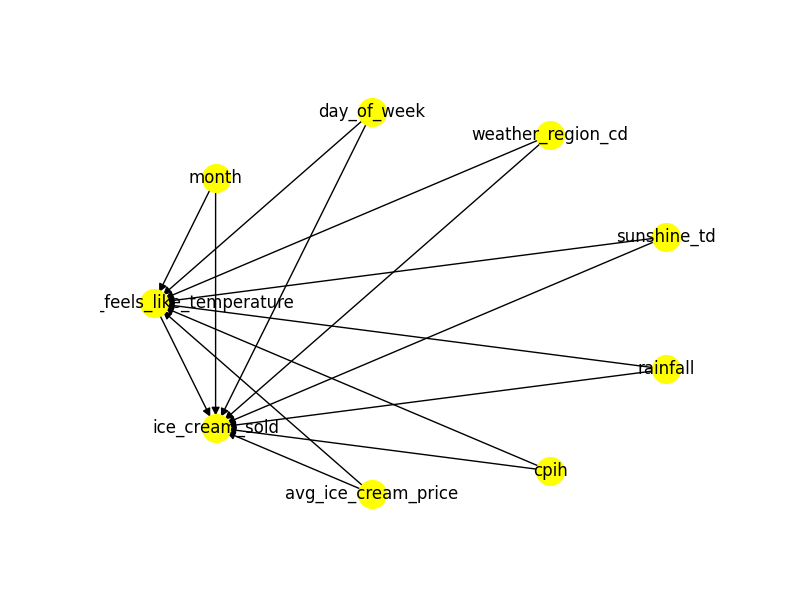

In [7]:
model = CausalModel(
    data=df,
    treatment=treatment, 
    outcome=outcome, 
    common_causes=covariates, 
    instruments=None, 
    effect_modifiers=None)

display(Image(filename="../figures/causal_model.png"))

# Estimate Causal Effects

In [8]:
est = CausalForestDML(
                        model_y=RandomForestRegressor(criterion='absolute_error')
                      , model_t=RandomForestRegressor(min_samples_leaf=10, criterion='absolute_error')
                      , discrete_treatment=False
                  )

In [9]:
# fit through dowhy
est_dw = est.dowhy.fit(Y, T, X=X, W=W, outcome_names=[outcome], treatment_names=[treatment], feature_names=covariates,
               confounder_names=features, inference="auto")

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [10]:
# estimate the CATE with the test set 
est_dw.const_marginal_ate(X_test)[0]

In [11]:
est_dw.estimate_.interpret()

Increasing the treatment variable(s) [maximum_feels_like_temperature] from [0] to [1] causes an increase of 263.87869940061006 in the expected value of the outcome [ice_cream_sold], over the data distribution/population represented by the dataset.


In [12]:
shap_values = est_dw.shap_values(X)
shap.plots.beeswarm(shap_values['ice_cream_sold']['maximum_feels_like_temperature'])

 99%|===================| 5964/6035 [00:41<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [13]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3).interpret(est_dw, X)

plt.figure(figsize=(30,10))
intrp.plot(feature_names=X.columns, fontsize=12)

Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.


# Refutes!

Add Random Common Cause
How robust are our estimates to adding another confounder? We use DoWhy to test this!

In [14]:
res_random = est_dw.refute_estimate(method_name="random_common_cause", num_simulations=5)
print(res_random)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

Refute: Add a random common cause
Estimated effect:263.87869940061006
New effect:261.8361088155841
p value:0.4039106157953297



Add Unobserved Common Cause
How robust are our estimates to unobserved confounders? Since we assume the model is under unconfoundedness, adding an unobserved confounder might bias the estimates. We use DoWhy to test this!

In [15]:
res_unobserved = est_dw.refute_estimate(
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.1,
    effect_strength_on_outcome=0.1,
)
print(res_unobserved)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Refute: Add an Unobserved Common Cause
Estimated effect:263.87869940061006
New effect:257.18075356686484



Replace Treatment with a Random (Placebo) Variable
What happens our estimates if we replace the treatment variable with noise? Ideally, the average effect would be wildly different than our original estimate. We use DoWhy to investigate!

In [16]:
res_placebo = est_dw.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=3
)
print(res_placebo)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Refute: Use a Placebo Treatment
Estimated effect:263.87869940061006
New effect:2.8010272085578625
p value:0.17319022254278366



Remove a Random Subset of the Data
Do we recover similar estimates on subsets of the data? This speaks to the ability of our chosen estimator to generalize well. We use DoWhy to investigate this!

In [17]:
res_subset = est_dw.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=3)
print(res_subset)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Refute: Use a subset of data
Estimated effect:263.87869940061006
New effect:277.42392990232196
p value:0.10075441308844302

